##### **Background**

The aim of this final part (part 3) for the pills dataset was really for me to start using Rust in a beginner-friendly way. Overall, this trilogy (parts 1 - 3) for the pills dataset formulated an overview of how to use Polars in Python (mainly), Pandas in Python (smaller section) and Polars in Rust (even little less as this was new to me) with Plotly. Over time, I've been finding myself learning more optimally by doing and applying, rather than just reading and thinking, so I've got myself started in this very new programming language, Rust, to get some familiarities. I anticipated that I would still work with Python and R mainly in the near future, so that I'm not diverting too much and would be at least proficient in at least one programming language.

My very initial idea was to integrate Rust-Polars, Plotly in Rust (Plotly.rs) and Jupyter-Evcxr together, and see if I could get a simple data visualisation out of a small dataset. Although the idea sounded simple enough, I was actually quite stuck at the step of importing one of the columns as x-axis variables in Rust-Polars to Plotly.rs. I figured it might possibly be due to my very lack-of-knowledge and lack-of-familiarities with Rust (I do need to continue reading the Rust programming language book), Polars (I'm better with Python-Polars actually), Plotly.rs and also Evcxr. Another possibility could be that Plotly.rs mainly had ndarray support, and Polars was not mentioned explicitly in Plotly.rs so my guess was that these two might not flow very well together. Also, Polars itself was constantly evolving and growing as well.

So I've decided to leave things as how it would be for now, before I delayed this post any further. If I happened to figure out how to do this in the future, then I'll come back to update this last part of the project. While I was tackling this little issue mentioned above, somehow I've managed to deconstruct Polars dataframe in Rust in Evcxr. So I'll show a little bit about it below. One slightly good news that came out from all of this, was that I've managed to import the other column as y-axis variables, which contained numbers, without problems. I've also figured out the Rust codes to convert Series/ChunkedArray to vectors in Rust IDEs (e.g. VS Code, and quite a few others). So I did learn a few things while completing this post, and hoped I could expand further on this later.

**Note: I've published all Rust codes as print-only in Quarto markdown file, since it's not possible to run them in RStudio IDE (Rust was not supported). So all Rust codes were originally run on Jupyter Lab in MacOS, with code outputs being captured as screenshots, which were shown as photos in this post. Here's the [link](https://github.com/jhylin/Rust_projects/blob/main/Rust_evcxr_polars_plotly_final.ipynb) to the .ipynb file in the GitHub repository for this portfolio website (or alternatively, you could access it from the GitHub icon link at the top of the web page), in case anyone wanted to see the full .ipynb version.**


##### **Import dependencies**

These dependencies were known as crates in the world of Rust. I'd also like to think of them as libraries or packages we would install or import in Python and R. So this step was necessary before I even started anything decent in Rust. Similar things would also apply to Rust IDEs as well since I've played a little bit in VS Code previously.

In [2]:
// Set up required dependencies
:dep ndarray = "0.15.6"

In [3]:
:dep plotly = { version = ">=0.8.0", features = ["plotly_ndarray"]}

In [4]:
// May take a few minutes to load polars crate (might depend on your machine specs)
:dep polars = { version = ">=0.26.0", features = ["lazy", "csv-file", "strings", "dtype-duration", "dtype-categorical", "concat_str", "rank", "lazy_regex", "ndarray"]}

In [5]:
:dep itertools = {version = "0.9.0"}

##### **Import external crates**

In [6]:
// Import external crates needed
extern crate ndarray;
extern crate plotly;
extern crate polars;

##### **Specify imports or modules required**

In [7]:
use ndarray::prelude::*;
use polars::prelude::*;
use plotly::common::{
    ColorScale, ColorScalePalette, DashType, Fill, Font, Line, LineShape, Marker, Mode, Title,
};
use plotly::layout::{Axis, BarMode, Layout, Legend, TicksDirection};
use plotly::{Plot, Scatter, Bar};
use itertools::Itertools;

##### **Reading csv file**

Here, I've imported the .csv file saved from part 2 of the project.

In [8]:
// Reading .csv file
let df = CsvReader::from_path("ace_para_count.csv").unwrap().finish().unwrap();

In [9]:
df

shape: (6, 2)
┌──────────────┬───────┐
│ Colour       ┆ count │
│ ---          ┆ ---   │
│ str          ┆ i64   │
╞══════════════╪═══════╡
│ RED          ┆ 1     │
│ ORANGE;BROWN ┆ 1     │
│ YELLOW;WHITE ┆ 1     │
│ ORANGE       ┆ 1     │
│ WHITE        ┆ 7     │
│ BLUE         ┆ 2     │
└──────────────┴───────┘

##### **Converting columns into ndarrays**

I've tested plotting in Plotly.rs after a few trials and errors at the beginning, but luckily I've spotted the ndarray support from the [Plotly.rs book](https://igiagkiozis.github.io/plotly/content/plotly_rs.html) soon enough to figure out that I could convert the "count" column into a ndarray first, which was shown in the code below.

In [10]:
// Switch Polars dataframe into 2D array
// Ensure "ndarray" was added as one of the features for polars under dependencies

/*Example from Polars documentation:
let df = DataFrame::new(vec![a, b]).unwrap();
let ndarray = df.to_ndarray::<Float64Type>().unwrap();
println!("{:?}", ndarray);
*/

//Note: ndarray for numbers only, not strings, so only "count" column was converted
let ndarray = df.to_ndarray::<Float64Type>().unwrap();
println!("{:?}", ndarray);

[[NaN, 1.0],
 [NaN, 1.0],
 [NaN, 1.0],
 [NaN, 1.0],
 [NaN, 7.0],
 [NaN, 2.0]], shape=[6, 2], strides=[1, 6], layout=Ff (0xa), const ndim=2


##### **Deconstructing Polars dataframe in Rust**

Because "to_ndarray" was only for numerics and not strings, I ran into a problem trying to figure out how to best import this other "Colour" column into Plotly.rs. This led to my little convoluted journey to work with Polars dataframe in Rust, trying to see if I could convert the "Colour" column into a vector (which might not be the best way to do it, but as part of my Rust learning, I went for it anyway). I've subsequently tried plotting the "count" column in ndarray as a vector with success, based on the reference from Plotly.rs book that variables for x or y-axis could be placed into a vector by using a vector macro. Eventually, I didn't quite achieve my goal but I've managed to break down or convert the Polars dataframe into different formats.

In [11]:
// Select specific column or series by position
let Colours = df[0].clone();

//Alternative way to select specific column or series by name
//let u = df.select_series(&["Colour"]);

In [12]:
Colours

shape: (6,)
Series: 'Colour' [str]
[
	"RED"
	"ORANGE;BROWN"
	"YELLOW;WHITE"
	"ORANGE"
	"WHITE"
	"BLUE"
]

There was a mention of storing series (column) in a vec (as series vector, not vector for strings) in Polars' documentation, which I've tried to plot in Plotly.rs, but it unfortunately failed to work. One of my guesses could be due to the data type used for vector, as Rust was a very type-specific programming language, which also brought its well-known memory safety and other benefits in the long run. My immediate thought was that it probably needed to be a vector for strings, not series, which might make it work. Then I was searching on StackOverflow for similar questions and answers, then I found something related to what I wanted to do from Polars documentations as shown below.

In [ ]:
// Adapted from: https://docs.rs/polars/latest/polars/docs/eager/index.html#series 
// Extracting data: 
// To be able to extract data out of Series, 
// either by iterating over them or converting them to other datatypes like a Vec<T>, 
// we first need to downcast them to a ChunkedArray<T>. 
// This is needed because we don't know the data type that is held by the Series.

/*use polars::prelude::*; 
  use polars::df;

  fn extract_data() -> PolarsResult<()> { 
  let df = df! [ "a" => [None, Some(1.0f32), Some(2.0)], "str" => ["foo", "bar", "ham"]]?;

// first extract ChunkedArray to get the inner type.

  let ca = df.column("a")?.f32()?;

// Then convert to vec

  let _to_vec: Vec<Option<f32>> = Vec::from(ca);

// We can also do this with iterators

  let ca = df.column("str")?.utf8()?; 
  let _to_vec: Vec<Option<&str>> = ca.into_iter().collect(); 
  let _to_vec_no_options: Vec<&str> = ca.into_no_null_iter().collect();

  Ok(())

}*/

Initially, I trialled the iterator function first.

In [13]:
// Print out items in column by applying an iterator to it
println!("{}", &Colours.iter().format("\n"));

"RED"
"ORANGE;BROWN"
"YELLOW;WHITE"
"ORANGE"
"WHITE"
"BLUE"


Then, it took me quite a long time to just downcast Series into ChunkedArray, but somehow I've managed to figure out the code myself below. One of the likely reasons was due to my choice of using Evcxr, which required Rust codes in slightly different formats than the ones in Rust IDEs (although almost the same).

In [14]:
// Somehow worked out how to convert series to chunkedarray by accident!
println!("{:?}", Colours.utf8().unwrap());

shape: (6,)
ChunkedArray: 'Colour' [str]
[
	"RED"
	"ORANGE;BROWN"
	"YELLOW;WHITE"
	"ORANGE"
	"WHITE"
	"BLUE"
]


Then I moved onto trying to figure out how to convert or place a ChunkedArray into a vector, with the closest answer shown below. However, bear in mind that these Rust codes were for Rust IDEs, and not for Evcxr, so this added slightly more complexities to what I was trying to do (perhaps I should just stick with Rust IDEs in the future...).

In [ ]:
//Adpated from StackOverflow - How to get a Vec from polars Series or ChunkedArray?
//You can collect the values into a Vec.

/*use polars::prelude::*;

fn main() -> Result<()> { let s = Series::new("a", 0..10i32);

    let as_vec: Vec<Option<i32>> = s.i32()?.into_iter().collect();

    //if we are certain we don't have missing values
    let as_vec: Vec<i32> = s.i32()?.into_no_null_iter().collect();
    Ok(())

}*/

I also found another way to iterate the ChunkedArray.

In [ ]:
//fn iter_forward(ca: &Float32Chunked) { ca.into_iter().for_each(|opt_v| println!("{:?}", opt_v)) } 

I then tested another iterator method, and came up with another line of code as shown below, which listed the colours in the "Colour" column.

In [15]:
Colours.utf8().unwrap().into_iter().for_each(|array|println!("{:?}", array));

Some("RED")
Some("ORANGE;BROWN")
Some("YELLOW;WHITE")
Some("ORANGE")
Some("WHITE")
Some("BLUE")


I also found out, randomly, how to slice strings for Series in Polars. By changing the number of letters to slice through in Some(), the strings or words would vary length accordingly. Here, I've used "15" so it covered all the colours (note: the longest would be 12 characters for combination colours).

In [16]:
// Another method to use if needing to slice strings
let x = Colours.utf8().unwrap().str_slice(0, Some(15));
x

Ok(shape: (6,)
ChunkedArray: 'Colour' [str]
[
	"RED"
	"ORANGE;BROWN"
	"YELLOW;WHITE"
	"ORANGE"
	"WHITE"
	"BLUE"
])

Lastly, before I got too carried away, I just wanted to show the method from Polars documentations that this was the Polars' way to select a specific column from Polars dataframe.

In [17]:
let ca = df.clone().lazy().select([cols(["Colour"])]).collect()?;
ca

shape: (6, 1)
┌──────────────┐
│ Colour       │
│ ---          │
│ str          │
╞══════════════╡
│ RED          │
│ ORANGE;BROWN │
│ YELLOW;WHITE │
│ ORANGE       │
│ WHITE        │
│ BLUE         │
└──────────────┘

##### **Plotting Polars dataframe in Plotly.rs**

For the x-axis, eventually, I reverted for manual input due to the issue mentioned in the background section. So the colours from the "Colour" column were stored in a vector set up manually, rather than coming directly from the dataframe. While searching for answers, I've also learnt several other tricks, although not really solving the problem, they might still be useful in the future. For the y-axis, the ndarray for the "count" column was converted into a vector first before being fed into the trace (graph module), and thankfully the plot worked nicely.

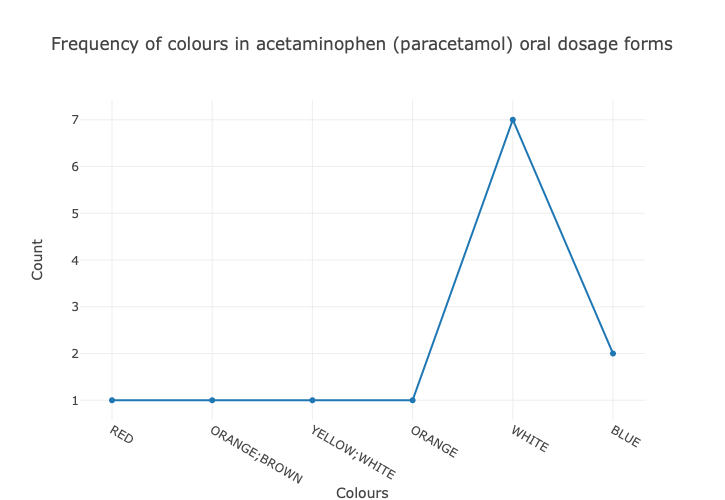

In [18]:
// MANUAL method:
// Use vec! macro to create new vectors to hold x variables (words as strings)
// Manually input the colour names (as ndarray is only for numbers)
let x = vec!["RED", "ORANGE;BROWN", "YELLOW;WHITE", "ORANGE", "WHITE", "BLUE"];

// Plot using ndarray, which is supported by Plotly.rs 
// Polars likely not supported yet
// Convert ndarray (holding counts as y variables) into vector 
let y = ndarray.column(1).to_vec();

// Use trace as a graph module,
// choose type of plots needed for x & y variables called
// Graph options e.g. Scatter, Line or Bar
let trace = Scatter::new(x, y);

// Set plot variable as mutable and initiate a plot
let mut plot = Plot::new();
// Add trace (graph) into the plot variable
plot.add_trace(trace);

// Specify the specs for plot
let layout = Layout::new()
    // Choose height of graph
    .height(500)
    // Name x-axis
    .x_axis(Axis::new().title(Title::new("Colours")))
    // Name y-axis
    .y_axis(Axis::new().title(Title::new("Count")))
    // Add title of graph
    .title(Title::new("Frequency of colours in acetaminophen (paracetamol) oral dosage forms"));

// Set the layout of the plot
plot.set_layout(layout);

// Display the plot in Jupyter Lab format 
// For Jupyter Notebook, use: plot.notebook_display();
plot.lab_display();
format!("EVCXR_BEGIN_CONTENT application/vnd.plotly.v1+json\n{}\nEVCXR_END_CONTENT", plot.to_json())

##### **Conclusion**

This last part was the hardest for me to execute out of all 3 parts (it likely took me a good whole week to figure out deconstructing Polars dataframe and trying to work with vectors), as Rust was completely new to me. At one point I thought about jumping back to Python, but I persisted and although I didn't quite solve the string importation issue, I was somehow happy that I was at least able to see how this programming language could be applied in Polars dataframe library. I also got a taste of using Rust in data visualisations. All I wanted to show was that there were a variety of data tools to use, and knowing your tools of trade would be the most critical when working on different data projects as certain tools would only work the best for certain tasks and scenarios. This warm-up lesson in Rust was quite interesting and I might continue either in VS Code or Evcxr depending on my next topic of interest.


##### **References**

[Rust programming language book](https://doc.rust-lang.org/book/title-page.html): https://doc.rust-lang.org/book/title-page.html

[Polars crate documentations](https://docs.rs/polars/latest/polars/): https://docs.rs/polars/latest/polars/

[Plotly.rs GitHub repository](https://github.com/igiagkiozis/plotly): https://github.com/igiagkiozis/plotly (link to the Plotly.rs book can be found in "Converting columns into ndarrays" section)

[Evcxr GitHub repository](https://github.com/google/evcxr): https://github.com/google/evcxr